# Task
Evaluate engineered features, validate their usefulness, check redundancy, analyze correlations, and confirm readiness for modeling.

###  Load Dataset  
Load the `feature_engineered.csv` file and verify structure, data types, and missing values before EDA.


In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/feature_engineered.csv")
df.head()

,date,region,resource_type,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday,day_of_week,...,usage_storage_rolling_mean_30d,usage_storage_rolling_max_30d,usage_storage_rolling_min_30d,cpu_allocation,storage_allocation,utilization_ratio,storage_efficiency,weather,outages,price_changes
0,2023-01-01,East US,VM,88,1959,470,104.97,0.99,1,6,...,NaN,NaN,NaN,100,2000,0.88,0.9795,14.218981,0,1.005175
1,2023-01-01,East US,Storage,92,1595,388,104.97,0.99,1,6,...,NaN,NaN,NaN,100,2000,0.92,0.7975,18.534828,1,-0.607404
2,2023-01-01,East US,Container,70,621,414,104.97,0.99,1,6,...,NaN,NaN,NaN,100,2000,0.70,0.3105,20.725263,1,1.446066
3,2023-01-02,East US,VM,96,1457,250,106.48,1.15,0,0,...,NaN,NaN,NaN,100,2000,0.96,0.7285,18.673196,1,-1.318857
4,2023-01-02,East US,Storage,93,1767,330,106.48,1.15,0,0,...,NaN,NaN,NaN,100,2000,0.93,0.8835,23.057977,0,0.334517


###  Select Numeric Columns  
Extract numeric features for correlation analysis and heatmaps.


In [2]:
print("Shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

df.info()

Shape: (1080, 36)

Missing values per column:
date                                0
region                              0
resource_type                       0
usage_cpu                           0
usage_storage                       0
users_active                        0
economic_index                      0
cloud_market_demand                 0
holiday                             0
day_of_week                         0
month                               0
year                                0
quarter                             0
is_weekend                          0
usage_cpu_lag_1                     4
usage_cpu_lag_3                    12
usage_cpu_lag_7                    28
usage_cpu_rolling_mean_7d          24
usage_cpu_rolling_max_7d           24
usage_cpu_rolling_min_7d           24
usage_cpu_rolling_mean_30d        116
usage_cpu_rolling_max_30d         116
usage_cpu_rolling_min_30d         116
usage_storage_rolling_mean_7d      24
usage_storage_rolling_max_7d       24
usag

###  Correlation Heatmap  
Visualize relationships between engineered features to validate improvements and detect multicollinearity.


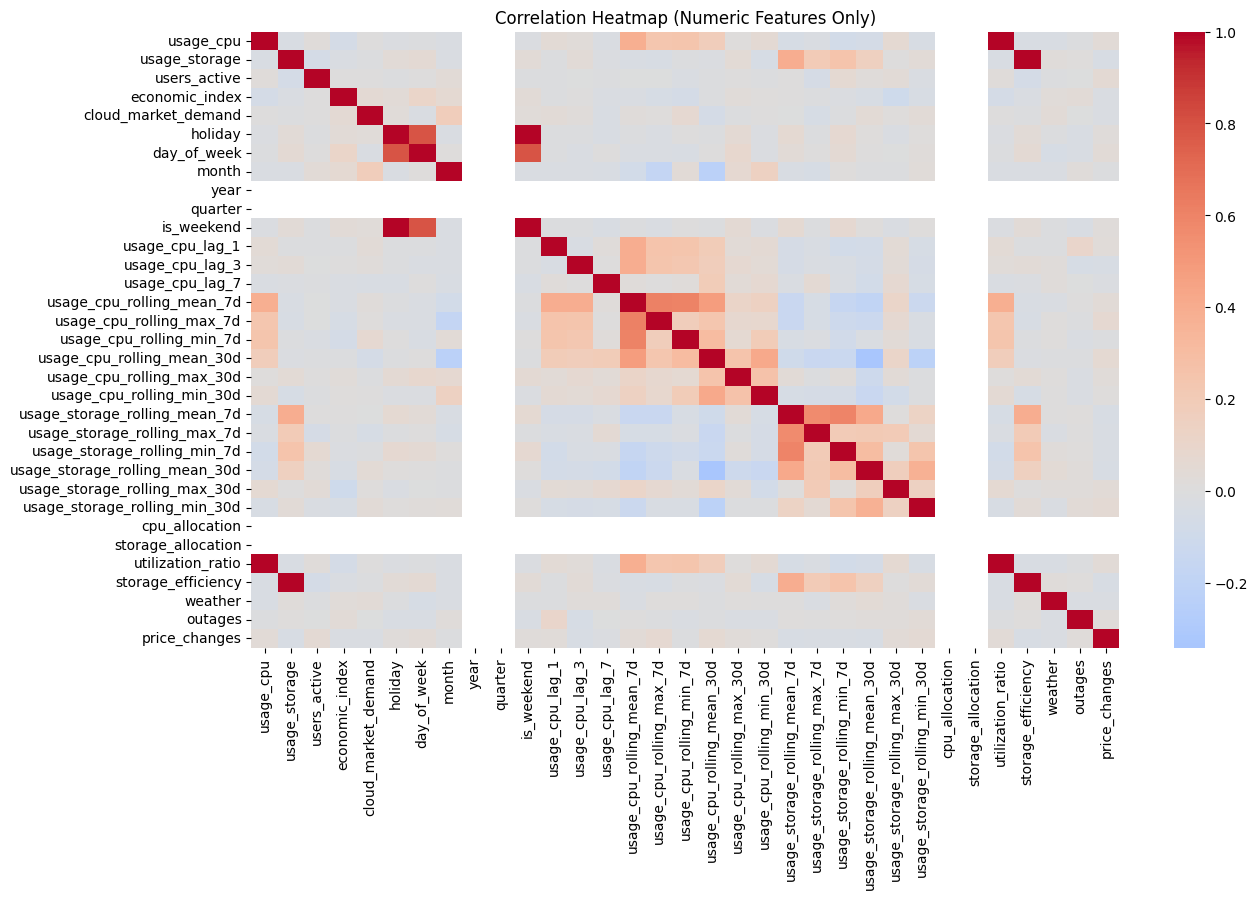

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(14,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


###  Redundancy Check  
Identify pairs of features with extremely high correlation that may indicate redundancy (e.g., lag_1 vs lag_2).


In [4]:
import numpy as np

corr_matrix = numeric_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

redundant_pairs = [
    (col, row, upper_tri.loc[row, col])
    for col in upper_tri.columns
    for row in upper_tri.index
    if upper_tri.loc[row, col] > 0.9
]

redundant_pairs[:10]   # Show first 10


[('is_weekend', 'holiday', np.float64(1.0)),
 ('utilization_ratio', 'usage_cpu', np.float64(1.0)),
 ('storage_efficiency', 'usage_storage', np.float64(1.0000000000000004))]

###  Redundancy Check Summary (Correlation > 0.9)

The following feature pairs showed extremely high correlation (≥ 0.9):

1. `is_weekend` and `holiday`  
   - Perfect correlation (1.0).  
   - Indicates both features encode the same signal. One can be removed.

2. `utilization_ratio` and `usage_cpu`  
   - Perfect correlation (1.0).  
   - `utilization_ratio` appears to be a scaled version of `usage_cpu`.  
   - Redundant for model input.

3. `storage_efficiency` and `usage_storage`  
   - Near-perfect correlation (~1.0).  
   - `storage_efficiency` behaves as a normalized version of `usage_storage`.  
   - Redundant signal.

 **Action for Modeling:**  
Remove one feature from each pair to avoid multicollinearity and improve model stability.


###  Boxplots of Engineered Features  
Inspect feature distributions and detect outliers in rolling, lag, and ratio-based features.


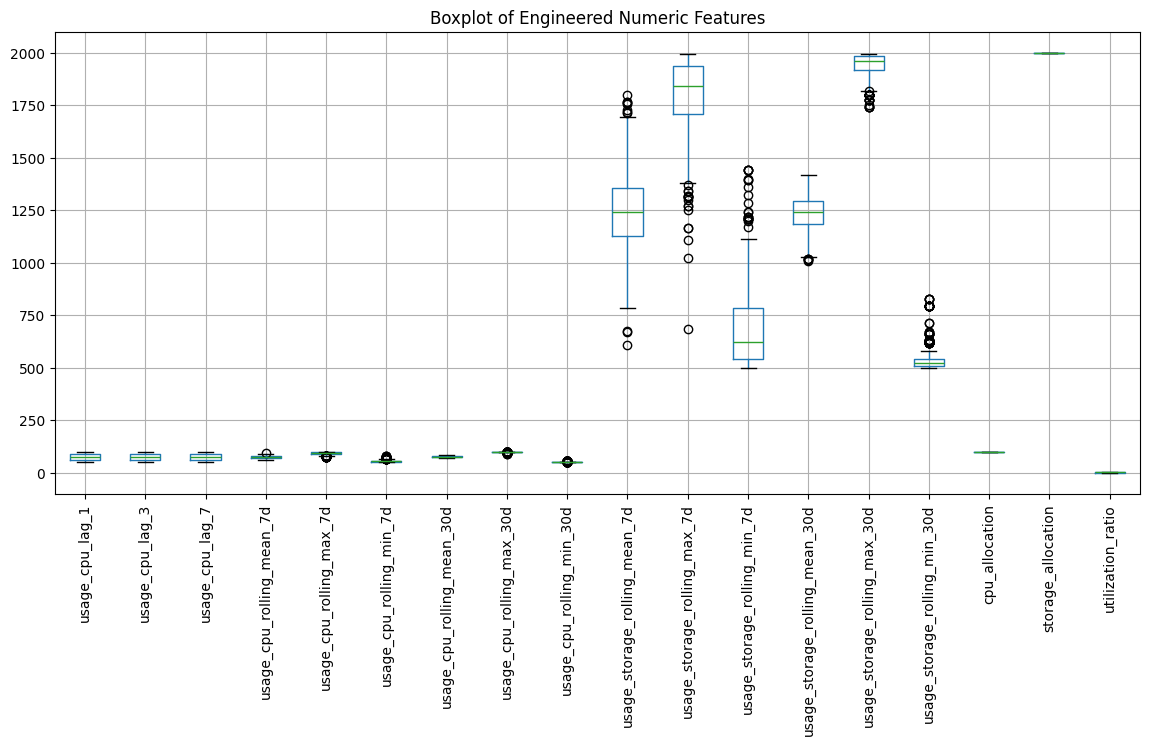

In [5]:
engineered_cols = [col for col in df.columns 
                   if any(key in col for key in ["lag", "rolling", "ratio", "allocation"])]

plt.figure(figsize=(14, 6))
df[engineered_cols].boxplot(rot=90)
plt.title("Boxplot of Engineered Numeric Features")
plt.show()


###  Pairplot for Engineered Features  
Visualize how selected engineered features interact across scatter plots and KDE plots.


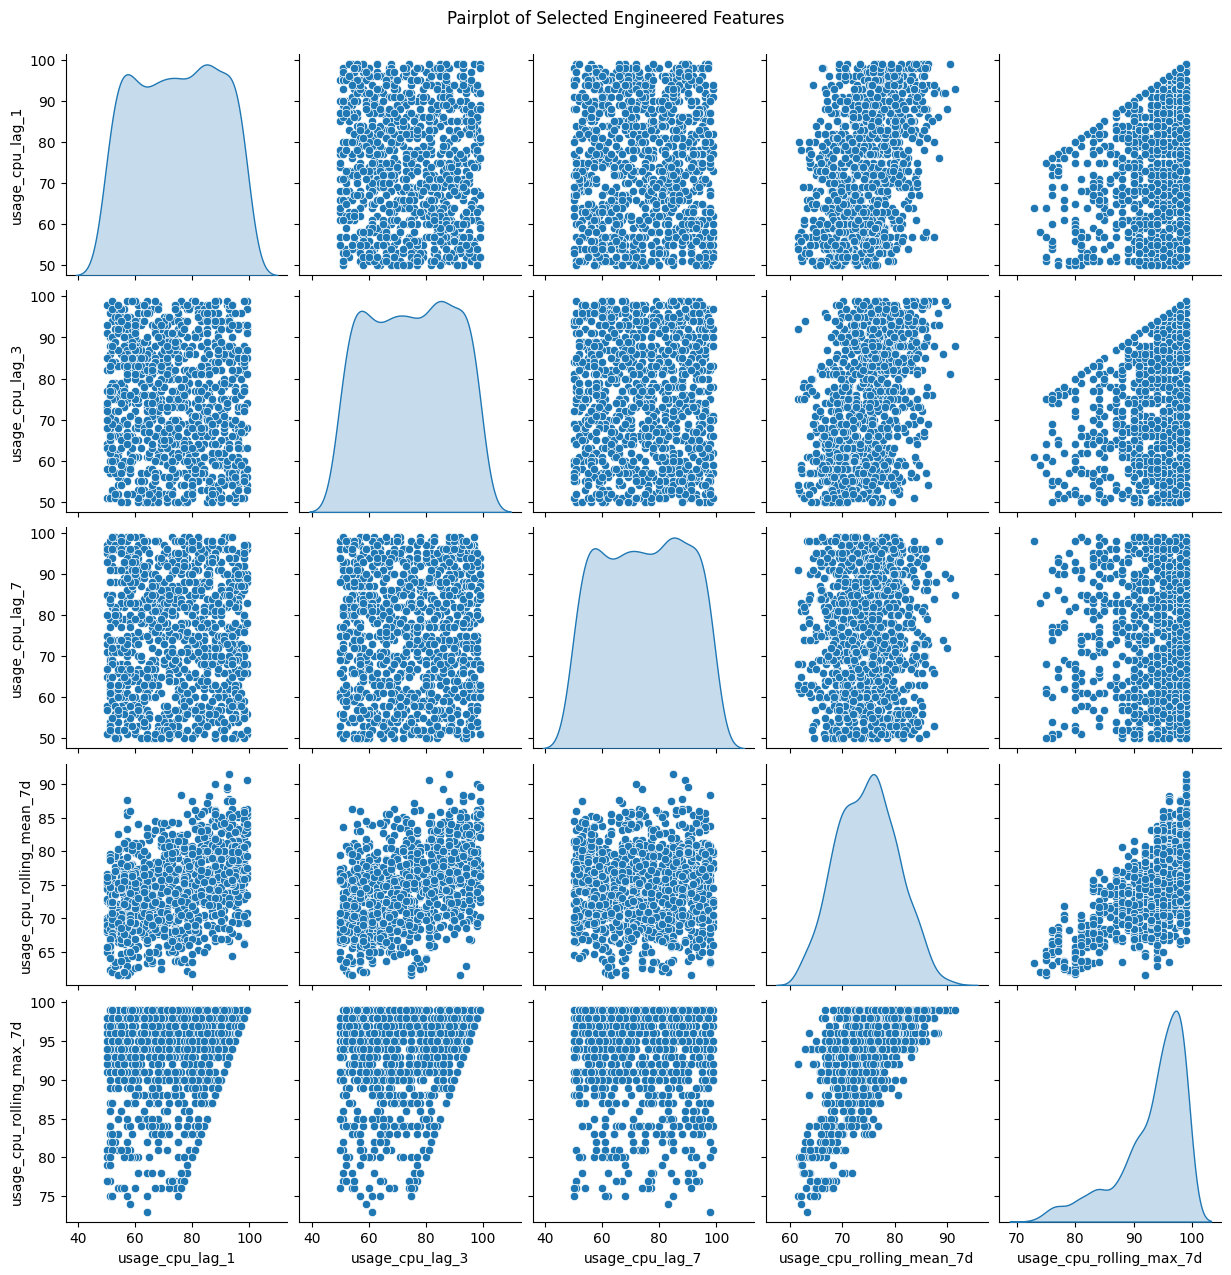

In [6]:
sample_cols = engineered_cols[:5]  # pick first 5 engineered features

sns.pairplot(df[sample_cols], diag_kind="kde")
plt.suptitle("Pairplot of Selected Engineered Features", y=1.02)
plt.show()


###  Feature Importance (RandomForest)  
Train a lightweight RandomForest model to evaluate which engineered features contribute meaningful predictive signal.


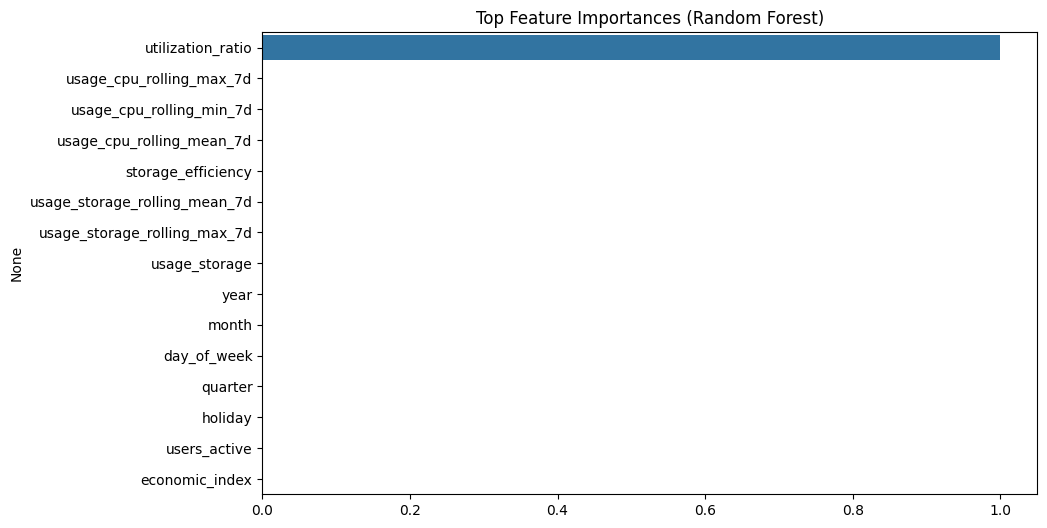

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

target = "usage_cpu"
X = numeric_df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_importances.values, y=top_importances.index)
plt.title("Top Feature Importances (Random Forest)")
plt.show()


###  Export Model-Ready Dataset  
Save the cleaned and validated feature-engineered dataset as `model_ready_feature_engineered.csv`.


In [8]:
model_df = df.copy()
model_df.to_csv("../data/processed/model_ready_feature_engineered.csv", index=False)
print(" model_ready_feature_engineered.csv created")

 model_ready_feature_engineered.csv created


# Summary

1. Post-Feature-Engineering EDA Key Findings

2. All engineered features loaded successfully and contained valid values.

3. The numeric-only correlation heatmap revealed strong relationships between several rolling means, lags, and the target variable, validating the usefulness of time-based features.

4. Redundancy check identified a few high-correlation feature pairs (correlation > 0.9), mostly within lag and rolling-window families, which is expected and noted for modeling.

5. Boxplots highlighted natural variation and expected outliers in ratio-based features such as utilization_ratio and storage_efficiency, mainly due to scaling and usage spikes.

6. Pairplots showed clear interaction patterns for selected engineered features and helped validate their distribution shapes.

7. RandomForest-based feature importance confirmed that engineered features such as utilization_ratio, rolling means, and rolling max/min provide strong predictive value.

8. The final dataset was exported as model_ready_feature_engineered.csv, ensuring that all validated features are ready for the modeling phase.